# 目标检测数据集

In [1]:
import torch
from d2l import torch as d2l
import os
import pandas as pd
import torchvision

In [2]:
d2l.DATA_HUB['banana-detection'] = (
    d2l.DATA_URL + 'banana-detection.zip',
    '5de26c8fce5ccdea9f91267273464dc968d20d72')

In [3]:
def read_data_bananas(is_train=True):
    data_dir = d2l.download_extract('banana-detection')
    csv_frame = os.path.join(data_dir, 'bananas_train' if is_train else 'bananas_val','label.csv')
    csv_data = pd.read_csv(csv_frame)
    csv_data = csv_data.set_index('img_name')
    images, targets = [],[]
    for img_name, target in csv_data.iterrows():
        images.append(torchvision.io.read_image(
            os.path.join(data_dir, 'bananas_train' if is_train else 'bananas_val', 'images', f'{img_name}')
        ))
        targets.append(list(target))
    # unsqueeze(1) 的作用是在第1维增加一个维度，把原来形状为(N, 4)的张量变成(N, 1, 4)，
    # 这样做通常是为了后续处理方便（比如和模型的输出形状对齐）
    return images, torch.tensor(targets).unsqueeze(1) / 256

In [4]:
from torch.utils.data.dataset import Dataset


class BananaDataset(Dataset):
    def __init__(self, is_train) -> None:
        super().__init__()
        self.features, self.labels = read_data_bananas(is_train=is_train)
        print('read ' + str(len(self.features)) + (f' training examples' if
              is_train else f' validation examples'))
    
    def __getitem__(self, index):
        return (self.features[index].float(), self.labels[index].float())

    def __len__(self):
        return len(self.features)

In [5]:
def load_banana_data(batch_size):
    train_iter = torch.utils.data.DataLoader(BananaDataset(is_train=True), batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(BananaDataset(is_train=False), batch_size, shuffle=False)
    return train_iter, test_iter

In [6]:
batch_size, edge_size = 32, 256
train_iter, _ = load_banana_data(batch_size)
batch = next(iter(train_iter))
batch[0].shape, batch[1].shape

read 1000 training examples
read 100 validation examples


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))

tensor([[0.0000, 0.5195, 0.6641, 0.7852, 0.8867]])
tensor([[0.0000, 0.8008, 0.2539, 0.9492, 0.4102]])
tensor([[0.0000, 0.1836, 0.6836, 0.4258, 0.8828]])
tensor([[0.0000, 0.5938, 0.5781, 0.8242, 0.7773]])
tensor([[0.0000, 0.4961, 0.0977, 0.7305, 0.3125]])
tensor([[0.0000, 0.4180, 0.7461, 0.6016, 0.9453]])
tensor([[0.0000, 0.3828, 0.5352, 0.5781, 0.6992]])
tensor([[0.0000, 0.7188, 0.6055, 0.8711, 0.7773]])
tensor([[0.0000, 0.5664, 0.6484, 0.7969, 0.8672]])
tensor([[0.0000, 0.6562, 0.4883, 0.9102, 0.6992]])


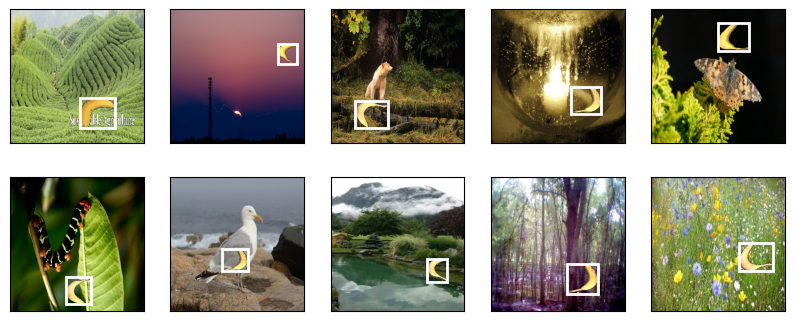

In [ ]:
# permute(0, 2, 3, 1) 的作用是对张量的维度进行重排列。原始的 batch[0][0:10] 的 shape 是 (10, 3, 256, 256)，
# 其中10是batch中的图片数量，3是通道数（RGB），256和256是图片的高和宽。
# permute(0, 2, 3, 1) 会将 shape 转换为 (10, 256, 256, 3)，即将通道维从第2维调换到最后一维，
# 这样可以便于后续用matplotlib显示图像，因为matplotlib要求图片shape最后一维是通道数。
imgs = (batch[0][0:10].permute(0,2,3,1)) / 255
axes = d2l.show_images(imgs, 2, 5, scale=2)
# zip(axes, batch[1][0:10]) 会将axes(每个图片的坐标轴对象)和 batch[1][0:10]（每张图片对应的标签）一一配对，方便同时迭代每张图片和它的标签
# 这里的 labels 实际还是一个 shape 为 (1, 5) 的 tensor（外层的 1 是之前 unsqueeze(1) 增加的批次维），所以 labels[0][0:5] 还是取出该图片的实际 label 数据
for ax, labels in zip(axes, batch[1][0:10]):
    print(labels)
    # 1:5 是因为 labels[0] 的第0位是类别标签，第1到4位是边界框坐标 [类别, x_min, y_min, x_max, y_max]
    # 这里只需要可视化边界框坐标部分，所以取 1:5（即索引 1,2,3,4）
    d2l.show_bboxes(ax, [labels[0][1:5] * edge_size], colors=['w'])